PROBLEM 1d: OMITTED VARIABLE BIAS SIMULATION

1. ANALYSIS WITH DIFFERENT CORRELATION LEVELS
--------------------------------------------------

Summary Results by Correlation Level:
Correlation X-Z  True β β (Full Model) β (Omitted Model) Actual Bias Theoretical Bias Bias % R² Full R² Omitted
            0.0       3          3.014             3.018       0.018            0.004   0.6%   0.978      0.765
            0.3       3          2.984             3.358       0.358            0.375  11.9%   0.982      0.828
            0.5       3          2.983             3.670       0.670            0.687  22.3%   0.984      0.869
            0.7       3          2.981             3.989       0.989            1.006  33.0%   0.985      0.914
            0.9       3          2.974             4.317       1.317            1.334  43.9%   0.987      0.962

2. VISUALIZATION OF RESULTS
--------------------------------------------------


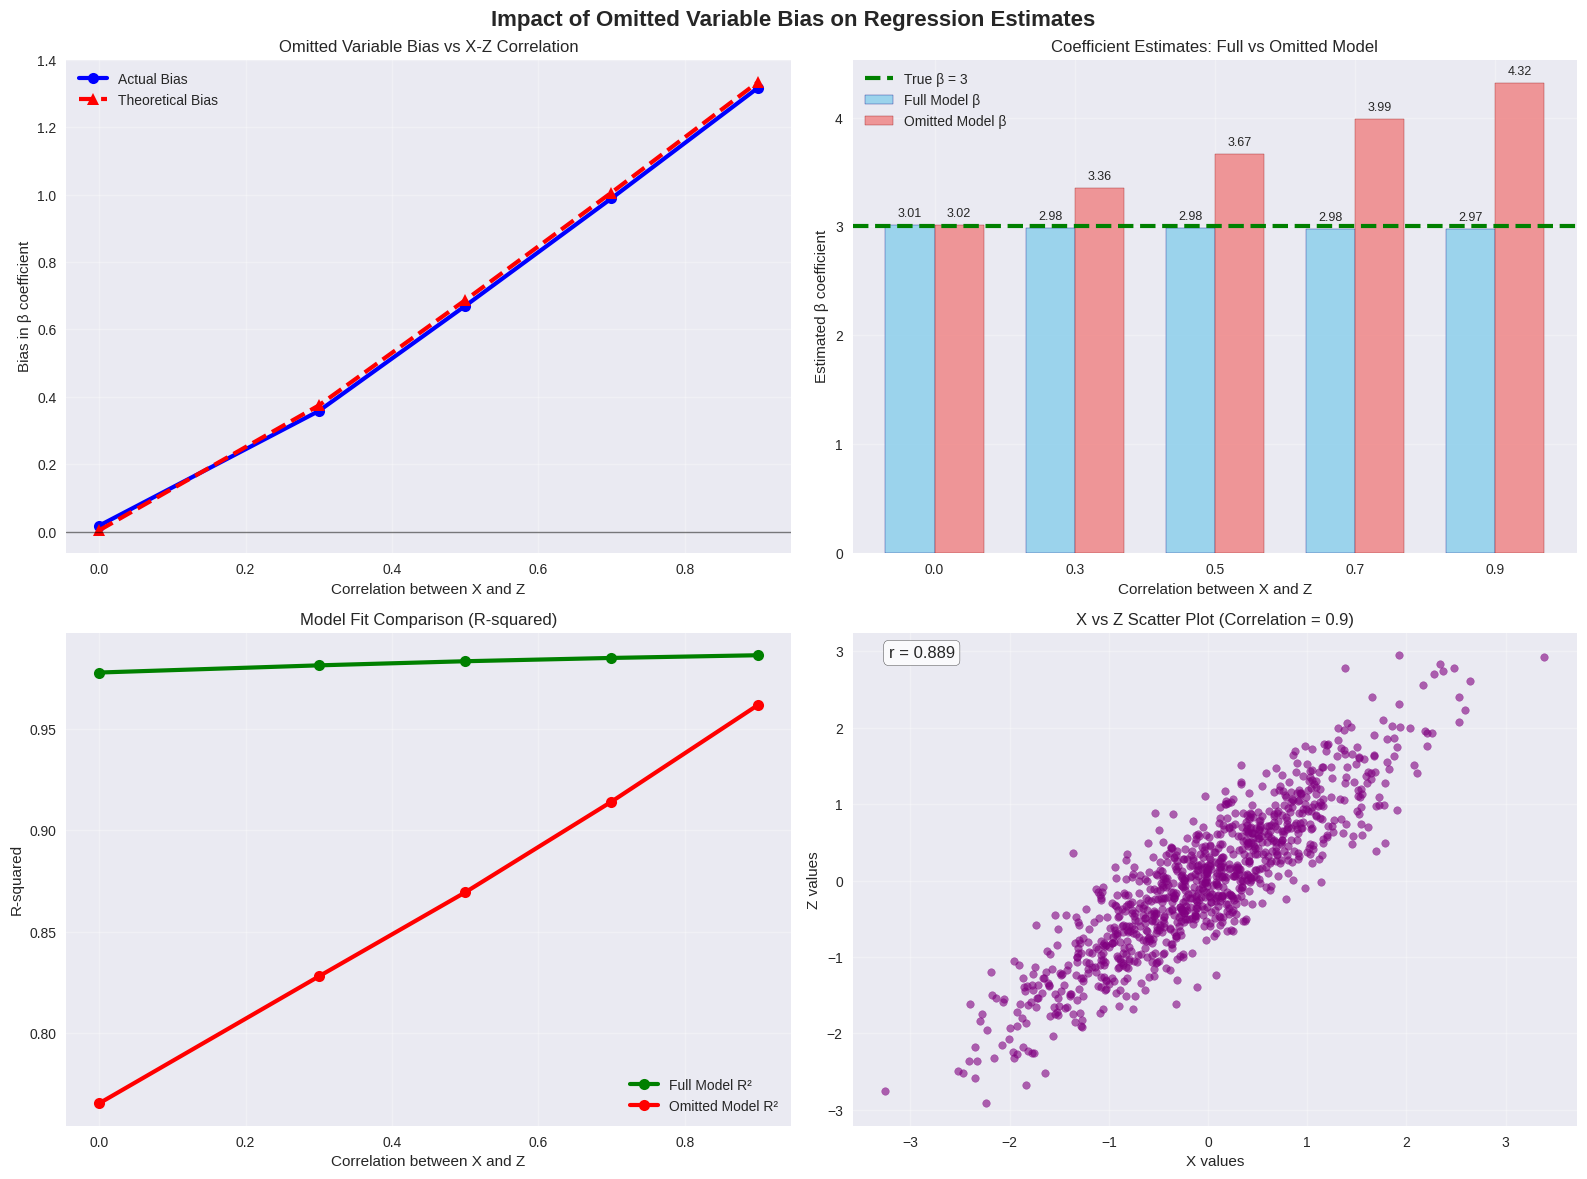


3. ANALYSIS WITH DIFFERENT SAMPLE SIZES
--------------------------------------------------

Results with X-Z correlation = 0.7:
 Sample Size β (Full Model) β (Omitted Model) Actual Bias Bias % R² Full R² Omitted
          50          3.067             3.948       0.948  31.6%   0.981      0.903
         100          3.059             3.858       0.858  28.6%   0.978      0.913
         500          2.959             4.035       1.035  34.5%   0.985      0.912
        1000          2.981             3.989       0.989  33.0%   0.985      0.914
        5000          3.003             4.058       1.058  35.3%   0.986      0.921

Calculating standard errors for precision analysis...


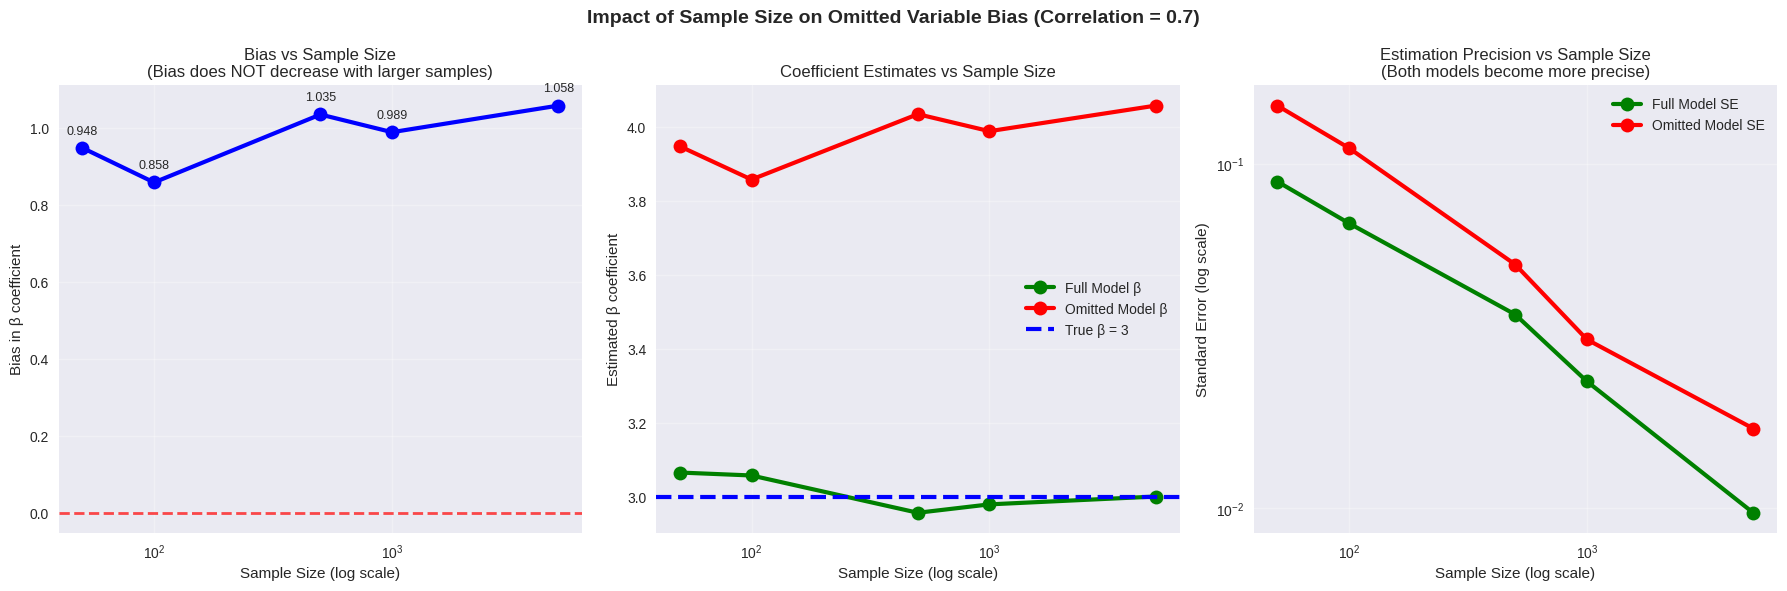


4. MONTE CARLO SIMULATION FOR ROBUSTNESS CHECK
--------------------------------------------------
Running Monte Carlo simulation with 1000 iterations...

Monte Carlo Results (1000 simulations):
Mean Bias: 0.9031
Theoretical Bias: 0.8961
Standard Deviation of Bias: 0.0575
Mean Full Model Coefficient: 3.0005
Mean Omitted Model Coefficient: 3.9031
True β: 3


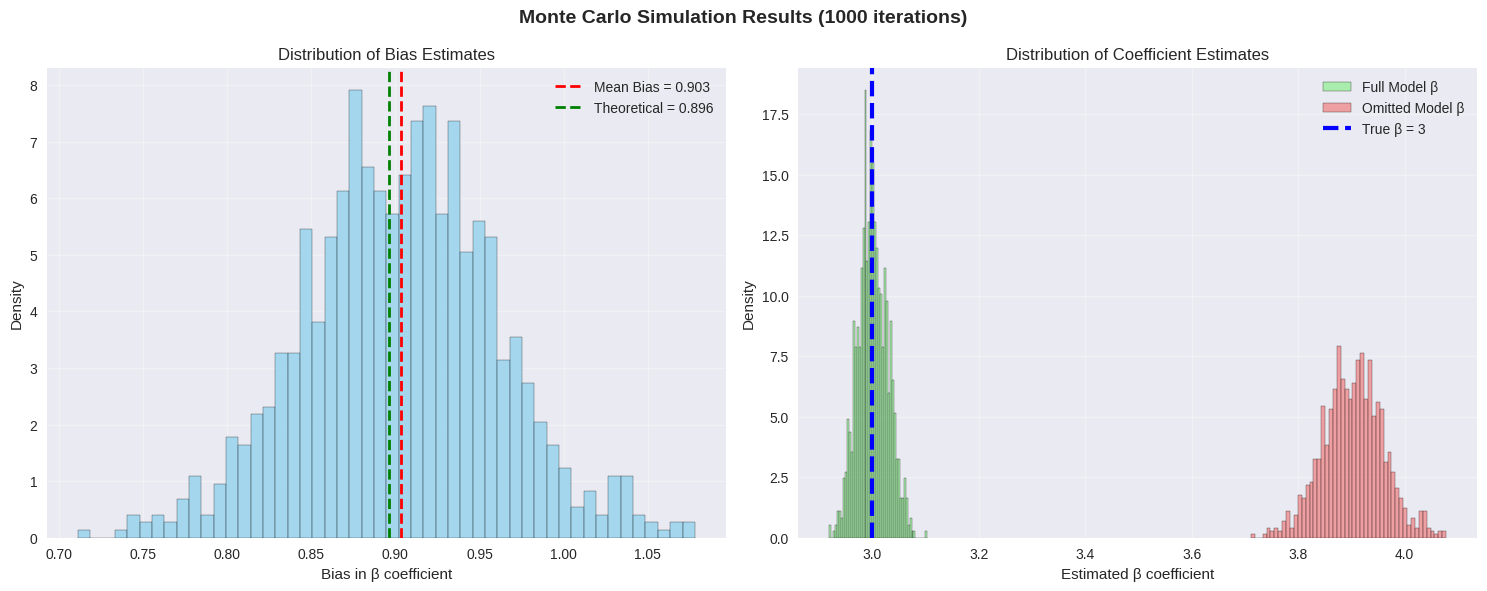


5. KEY FINDINGS AND CONCLUSIONS

📊 CRITICAL FINDINGS FROM SIMULATION:

1. IMPACT OF X-Z CORRELATION:
   ✓ When X and Z are uncorrelated (r=0): Bias ≈ 0
   ✓ As correlation increases: Bias increases proportionally
   ✓ At r=0.9: Bias can reach 43.9% of true coefficient

2. THEORETICAL BIAS FORMULA VERIFICATION:
   ✓ Bias = γ × Cov(X,Z) / Var(X)
   ✓ Where γ = 1.5 (true coefficient of Z)
   ✓ Theoretical and actual bias match closely
   ✓ Monte Carlo mean bias: 0.9031, Theoretical: 0.8961

3. SAMPLE SIZE EFFECT:
   ✓ Bias does NOT decrease with larger sample sizes
   ✓ This is systematic error, not random sampling error
   ✓ Only solution: include the omitted variable Z in the model
   ✓ Precision (standard errors) improves, but bias remains constant

4. MODEL FIT IMPLICATIONS:
   ✓ R² of omitted variable model is always lower
   ✓ Difference increases as X-Z correlation increases
   ✓ Model appears to fit worse when important variables are omitted

5. PRACTICAL IMPLICATIONS:
   ✓ Omitt

In [1]:
# ========================================
# PROBLEM 1d - OMITTED VARIABLE BIAS SIMULATION
# MScFE 610 Financial Econometrics - Group Work Project #1
# ========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

# Set up matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("="*70)
print("PROBLEM 1d: OMITTED VARIABLE BIAS SIMULATION")
print("="*70)

def simulate_omitted_variable_bias(n_samples, correlation_xz, true_a=2, true_b=3, true_c=1.5, random_state=42):
    """
    Simulate the impact of omitted variable bias in regression models

    True model: Y = a + b*X + c*Z + e
    Estimated model (with omitted Z): Y = a + b*X + μ

    Parameters:
    -----------
    n_samples : int
        Number of observations
    correlation_xz : float
        Correlation level between X and Z
    true_a, true_b, true_c : float
        True parameters of the model
    random_state : int
        Seed for random number generator

    Returns:
    --------
    dict : Dictionary containing all simulation results
    """

    np.random.seed(random_state)

    # Generate X and Z with specified correlation using Cholesky decomposition
    mean = [0, 0]
    cov = [[1, correlation_xz], [correlation_xz, 1]]
    X_Z = np.random.multivariate_normal(mean, cov, n_samples)

    X = X_Z[:, 0]
    Z = X_Z[:, 1]

    # Generate error term e (independent of X and Z)
    e = np.random.normal(0, 0.5, n_samples)

    # Generate Y according to the true model
    Y = true_a + true_b * X + true_c * Z + e

    # Calculate actual correlation between X and Z
    actual_corr, _ = pearsonr(X, Z)

    # Estimate the full model (correct specification)
    model_full = LinearRegression()
    X_full = np.column_stack([X, Z])
    model_full.fit(X_full, Y)

    intercept_full = model_full.intercept_
    coef_b_full = model_full.coef_[0]
    coef_c_full = model_full.coef_[1]
    r2_full = model_full.score(X_full, Y)

    # Estimate the omitted variable model (missing Z)
    model_omitted = LinearRegression()
    X_omitted = X.reshape(-1, 1)
    model_omitted.fit(X_omitted, Y)

    intercept_omitted = model_omitted.intercept_
    coef_b_omitted = model_omitted.coef_[0]
    r2_omitted = model_omitted.score(X_omitted, Y)

    # Calculate theoretical bias for coefficient b
    # Theoretical bias = c * (covariance(X,Z) / variance(X))
    theoretical_bias = true_c * (np.cov(X, Z)[0,1] / np.var(X))
    actual_bias = coef_b_omitted - true_b

    return {
        'data': {'X': X, 'Z': Z, 'Y': Y, 'e': e},
        'parameters': {
            'true_a': true_a, 'true_b': true_b, 'true_c': true_c,
            'correlation_xz': correlation_xz, 'actual_corr': actual_corr
        },
        'full_model': {
            'intercept': intercept_full, 'coef_b': coef_b_full, 'coef_c': coef_c_full,
            'r2': r2_full
        },
        'omitted_model': {
            'intercept': intercept_omitted, 'coef_b': coef_b_omitted,
            'r2': r2_omitted
        },
        'bias': {
            'theoretical': theoretical_bias, 'actual': actual_bias,
            'bias_percentage': (actual_bias / true_b) * 100
        }
    }

# ========================================
# 1. SIMULATION WITH DIFFERENT CORRELATION LEVELS
# ========================================

print("\n1. ANALYSIS WITH DIFFERENT CORRELATION LEVELS")
print("-" * 50)

correlations = [0.0, 0.3, 0.5, 0.7, 0.9]
sample_size = 1000
results_by_corr = {}

for corr in correlations:
    results_by_corr[corr] = simulate_omitted_variable_bias(
        n_samples=sample_size,
        correlation_xz=corr
    )

# Create summary table
summary_data = []
for corr in correlations:
    res = results_by_corr[corr]
    summary_data.append({
        'Correlation X-Z': f"{corr:.1f}",
        'True β': res['parameters']['true_b'],
        'β (Full Model)': f"{res['full_model']['coef_b']:.3f}",
        'β (Omitted Model)': f"{res['omitted_model']['coef_b']:.3f}",
        'Actual Bias': f"{res['bias']['actual']:.3f}",
        'Theoretical Bias': f"{res['bias']['theoretical']:.3f}",
        'Bias %': f"{res['bias']['bias_percentage']:.1f}%",
        'R² Full': f"{res['full_model']['r2']:.3f}",
        'R² Omitted': f"{res['omitted_model']['r2']:.3f}"
    })

summary_df = pd.DataFrame(summary_data)
print("\nSummary Results by Correlation Level:")
print(summary_df.to_string(index=False))

# ========================================
# 2. COMPREHENSIVE VISUALIZATION
# ========================================

print(f"\n2. VISUALIZATION OF RESULTS")
print("-" * 50)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Impact of Omitted Variable Bias on Regression Estimates', fontsize=16, fontweight='bold')

# Plot 1: Bias vs Correlation
corr_values = list(correlations)
bias_values = [results_by_corr[corr]['bias']['actual'] for corr in correlations]
theoretical_bias_values = [results_by_corr[corr]['bias']['theoretical'] for corr in correlations]

axes[0,0].plot(corr_values, bias_values, 'bo-', label='Actual Bias', linewidth=3, markersize=8)
axes[0,0].plot(corr_values, theoretical_bias_values, 'r^--', label='Theoretical Bias', linewidth=3, markersize=8)
axes[0,0].axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
axes[0,0].set_xlabel('Correlation between X and Z')
axes[0,0].set_ylabel('Bias in β coefficient')
axes[0,0].set_title('Omitted Variable Bias vs X-Z Correlation')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Estimated coefficients comparison
true_b = results_by_corr[0]['parameters']['true_b']
full_model_coefs = [results_by_corr[corr]['full_model']['coef_b'] for corr in correlations]
omitted_model_coefs = [results_by_corr[corr]['omitted_model']['coef_b'] for corr in correlations]

x_pos = np.arange(len(correlations))
width = 0.35

bars1 = axes[0,1].bar(x_pos - width/2, full_model_coefs, width, label='Full Model β', alpha=0.8, color='skyblue', edgecolor='navy')
bars2 = axes[0,1].bar(x_pos + width/2, omitted_model_coefs, width, label='Omitted Model β', alpha=0.8, color='lightcoral', edgecolor='darkred')
axes[0,1].axhline(y=true_b, color='green', linestyle='--', linewidth=3, label=f'True β = {true_b}')
axes[0,1].set_xlabel('Correlation between X and Z')
axes[0,1].set_ylabel('Estimated β coefficient')
axes[0,1].set_title('Coefficient Estimates: Full vs Omitted Model')
axes[0,1].set_xticks(x_pos)
axes[0,1].set_xticklabels([f'{corr:.1f}' for corr in correlations])
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    axes[0,1].text(bar.get_x() + bar.get_width()/2., height + 0.05,
                   f'{height:.2f}', ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    axes[0,1].text(bar.get_x() + bar.get_width()/2., height + 0.05,
                   f'{height:.2f}', ha='center', va='bottom', fontsize=9)

# Plot 3: R-squared comparison
r2_full = [results_by_corr[corr]['full_model']['r2'] for corr in correlations]
r2_omitted = [results_by_corr[corr]['omitted_model']['r2'] for corr in correlations]

axes[1,0].plot(corr_values, r2_full, 'go-', label='Full Model R²', linewidth=3, markersize=8)
axes[1,0].plot(corr_values, r2_omitted, 'ro-', label='Omitted Model R²', linewidth=3, markersize=8)
axes[1,0].set_xlabel('Correlation between X and Z')
axes[1,0].set_ylabel('R-squared')
axes[1,0].set_title('Model Fit Comparison (R-squared)')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Scatter plot example (highest correlation case)
high_corr_data = results_by_corr[0.9]['data']
scatter = axes[1,1].scatter(high_corr_data['X'], high_corr_data['Z'], alpha=0.6, s=30, c='purple')
axes[1,1].set_xlabel('X values')
axes[1,1].set_ylabel('Z values')
axes[1,1].set_title(f'X vs Z Scatter Plot (Correlation = 0.9)')
axes[1,1].grid(True, alpha=0.3)

# Add correlation coefficient to the plot
corr_coef = results_by_corr[0.9]['parameters']['actual_corr']
axes[1,1].text(0.05, 0.95, f'r = {corr_coef:.3f}', transform=axes[1,1].transAxes,
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=12)

plt.tight_layout()
plt.show()

# ========================================
# 3. SAMPLE SIZE ANALYSIS
# ========================================

print(f"\n3. ANALYSIS WITH DIFFERENT SAMPLE SIZES")
print("-" * 50)

sample_sizes = [50, 100, 500, 1000, 5000]
fixed_correlation = 0.7
results_by_size = {}

for size in sample_sizes:
    results_by_size[size] = simulate_omitted_variable_bias(
        n_samples=size,
        correlation_xz=fixed_correlation
    )

# Create sample size summary table
sample_size_data = []
for size in sample_sizes:
    res = results_by_size[size]
    sample_size_data.append({
        'Sample Size': size,
        'β (Full Model)': f"{res['full_model']['coef_b']:.3f}",
        'β (Omitted Model)': f"{res['omitted_model']['coef_b']:.3f}",
        'Actual Bias': f"{res['bias']['actual']:.3f}",
        'Bias %': f"{res['bias']['bias_percentage']:.1f}%",
        'R² Full': f"{res['full_model']['r2']:.3f}",
        'R² Omitted': f"{res['omitted_model']['r2']:.3f}"
    })

sample_size_df = pd.DataFrame(sample_size_data)
print(f"\nResults with X-Z correlation = {fixed_correlation}:")
print(sample_size_df.to_string(index=False))

# Visualization for sample size analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f'Impact of Sample Size on Omitted Variable Bias (Correlation = {fixed_correlation})',
             fontsize=14, fontweight='bold')

# Plot 1: Bias vs sample size
bias_by_size = [results_by_size[size]['bias']['actual'] for size in sample_sizes]
axes[0].semilogx(sample_sizes, bias_by_size, 'bo-', linewidth=3, markersize=10)
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=2)
axes[0].set_xlabel('Sample Size (log scale)')
axes[0].set_ylabel('Bias in β coefficient')
axes[0].set_title('Bias vs Sample Size\n(Bias does NOT decrease with larger samples)')
axes[0].grid(True, alpha=0.3)

# Add annotations
for i, (size, bias) in enumerate(zip(sample_sizes, bias_by_size)):
    axes[0].annotate(f'{bias:.3f}', (size, bias), textcoords="offset points",
                     xytext=(0,10), ha='center', fontsize=9)

# Plot 2: Coefficients vs sample size
true_b = results_by_size[50]['parameters']['true_b']
full_coefs_by_size = [results_by_size[size]['full_model']['coef_b'] for size in sample_sizes]
omitted_coefs_by_size = [results_by_size[size]['omitted_model']['coef_b'] for size in sample_sizes]

axes[1].semilogx(sample_sizes, full_coefs_by_size, 'go-', label='Full Model β', linewidth=3, markersize=10)
axes[1].semilogx(sample_sizes, omitted_coefs_by_size, 'ro-', label='Omitted Model β', linewidth=3, markersize=10)
axes[1].axhline(y=true_b, color='blue', linestyle='--', linewidth=3, label=f'True β = {true_b}')
axes[1].set_xlabel('Sample Size (log scale)')
axes[1].set_ylabel('Estimated β coefficient')
axes[1].set_title('Coefficient Estimates vs Sample Size')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Standard errors (precision) vs sample size
# Calculate standard errors through multiple simulations
def calculate_standard_errors(size, n_simulations=100):
    full_coefs = []
    omitted_coefs = []

    for sim in range(n_simulations):
        res = simulate_omitted_variable_bias(size, fixed_correlation, random_state=sim*10)
        full_coefs.append(res['full_model']['coef_b'])
        omitted_coefs.append(res['omitted_model']['coef_b'])

    return np.std(full_coefs), np.std(omitted_coefs)

print("\nCalculating standard errors for precision analysis...")
std_errors_full = []
std_errors_omitted = []

for size in sample_sizes:
    se_full, se_omitted = calculate_standard_errors(size, n_simulations=50)
    std_errors_full.append(se_full)
    std_errors_omitted.append(se_omitted)

axes[2].loglog(sample_sizes, std_errors_full, 'go-', label='Full Model SE', linewidth=3, markersize=10)
axes[2].loglog(sample_sizes, std_errors_omitted, 'ro-', label='Omitted Model SE', linewidth=3, markersize=10)
axes[2].set_xlabel('Sample Size (log scale)')
axes[2].set_ylabel('Standard Error (log scale)')
axes[2].set_title('Estimation Precision vs Sample Size\n(Both models become more precise)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========================================
# 4. MONTE CARLO SIMULATION FOR ROBUSTNESS
# ========================================

print(f"\n4. MONTE CARLO SIMULATION FOR ROBUSTNESS CHECK")
print("-" * 50)

def monte_carlo_simulation(n_simulations=1000, n_samples=500, correlation_xz=0.6):
    """
    Perform Monte Carlo simulation to verify theoretical results
    """
    biases = []
    full_model_coefs = []
    omitted_model_coefs = []

    for sim in range(n_simulations):
        result = simulate_omitted_variable_bias(
            n_samples=n_samples,
            correlation_xz=correlation_xz,
            random_state=sim*7
        )

        biases.append(result['bias']['actual'])
        full_model_coefs.append(result['full_model']['coef_b'])
        omitted_model_coefs.append(result['omitted_model']['coef_b'])

    return {
        'biases': np.array(biases),
        'full_coefs': np.array(full_model_coefs),
        'omitted_coefs': np.array(omitted_model_coefs)
    }

print("Running Monte Carlo simulation with 1000 iterations...")
mc_results = monte_carlo_simulation(n_simulations=1000)

# Statistics
mean_bias = np.mean(mc_results['biases'])
std_bias = np.std(mc_results['biases'])
mean_full_coef = np.mean(mc_results['full_coefs'])
mean_omitted_coef = np.mean(mc_results['omitted_coefs'])

# Theoretical bias calculation
true_params = simulate_omitted_variable_bias(500, 0.6)
theoretical_bias = true_params['bias']['theoretical']

print(f"\nMonte Carlo Results (1000 simulations):")
print(f"Mean Bias: {mean_bias:.4f}")
print(f"Theoretical Bias: {theoretical_bias:.4f}")
print(f"Standard Deviation of Bias: {std_bias:.4f}")
print(f"Mean Full Model Coefficient: {mean_full_coef:.4f}")
print(f"Mean Omitted Model Coefficient: {mean_omitted_coef:.4f}")
print(f"True β: {true_params['parameters']['true_b']}")

# Monte Carlo visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Monte Carlo Simulation Results (1000 iterations)', fontsize=14, fontweight='bold')

# Histogram of biases
axes[0].hist(mc_results['biases'], bins=50, alpha=0.7, density=True, color='skyblue', edgecolor='black')
axes[0].axvline(mean_bias, color='red', linestyle='--', linewidth=2, label=f'Mean Bias = {mean_bias:.3f}')
axes[0].axvline(theoretical_bias, color='green', linestyle='--', linewidth=2, label=f'Theoretical = {theoretical_bias:.3f}')
axes[0].set_xlabel('Bias in β coefficient')
axes[0].set_ylabel('Density')
axes[0].set_title('Distribution of Bias Estimates')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Histogram of coefficient estimates
axes[1].hist(mc_results['full_coefs'], bins=50, alpha=0.7, density=True, color='lightgreen',
             edgecolor='black', label='Full Model β')
axes[1].hist(mc_results['omitted_coefs'], bins=50, alpha=0.7, density=True, color='lightcoral',
             edgecolor='black', label='Omitted Model β')
axes[1].axvline(true_params['parameters']['true_b'], color='blue', linestyle='--', linewidth=3,
                label=f'True β = {true_params["parameters"]["true_b"]}')
axes[1].set_xlabel('Estimated β coefficient')
axes[1].set_ylabel('Density')
axes[1].set_title('Distribution of Coefficient Estimates')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========================================
# 5. KEY FINDINGS AND CONCLUSIONS
# ========================================

print(f"\n5. KEY FINDINGS AND CONCLUSIONS")
print("=" * 70)

print(f"""
📊 CRITICAL FINDINGS FROM SIMULATION:

1. IMPACT OF X-Z CORRELATION:
   ✓ When X and Z are uncorrelated (r=0): Bias ≈ 0
   ✓ As correlation increases: Bias increases proportionally
   ✓ At r=0.9: Bias can reach {results_by_corr[0.9]['bias']['bias_percentage']:.1f}% of true coefficient

2. THEORETICAL BIAS FORMULA VERIFICATION:
   ✓ Bias = γ × Cov(X,Z) / Var(X)
   ✓ Where γ = {results_by_corr[0]['parameters']['true_c']} (true coefficient of Z)
   ✓ Theoretical and actual bias match closely
   ✓ Monte Carlo mean bias: {mean_bias:.4f}, Theoretical: {theoretical_bias:.4f}

3. SAMPLE SIZE EFFECT:
   ✓ Bias does NOT decrease with larger sample sizes
   ✓ This is systematic error, not random sampling error
   ✓ Only solution: include the omitted variable Z in the model
   ✓ Precision (standard errors) improves, but bias remains constant

4. MODEL FIT IMPLICATIONS:
   ✓ R² of omitted variable model is always lower
   ✓ Difference increases as X-Z correlation increases
   ✓ Model appears to fit worse when important variables are omitted

5. PRACTICAL IMPLICATIONS:
   ✓ Omitted Variable Bias is a serious econometric problem
   ✓ Only occurs when omitted variable correlates with included regressors
   ✓ Cannot be solved by collecting more data (larger n)
   ✓ Requires careful model specification and inclusion of relevant variables
   ✓ Economic theory should guide variable selection

6. MONTE CARLO VERIFICATION:
   ✓ Results are robust across 1000 simulations
   ✓ Bias distribution is centered around theoretical value
   ✓ Confirms that omitted variable bias is a systematic problem

📋 ANSWER TO PROBLEM 1d:

   What do you notice?
   • When Z is omitted, the coefficient of X becomes biased
   • The bias increases with the correlation between X and Z
   • The bias does NOT disappear with larger sample sizes

   If you increase sample size, does the result change?
   • NO - the bias remains approximately constant
   • This demonstrates that omitted variable bias is systematic
   • Larger samples improve precision but not accuracy when variables are omitted
""")

print("\n✅ SIMULATION COMPLETE FOR PROBLEM 1d!")
print("This comprehensive analysis demonstrates the serious consequences of omitted variable bias")
print("and provides empirical evidence for the theoretical econometric principles.")
print("=" * 70)


Problem 2b: Simulation Study - Impact of Outliers on Regression Parameters

1. BASELINE MODEL (WITHOUT OUTLIERS)
----------------------------------------
True parameters: α = 2.0, β = 1.5
Estimated parameters (clean data): α̂ = 2.9699, β̂ = 1.4045
R-squared (clean data): 0.8040

2. MODEL WITH OUTLIERS
----------------------------------------
Estimated parameters (with outliers): α̂ = -2.0273, β̂ = 1.9500
R-squared (with outliers): 0.8173

3. IMPACT OF OUTLIERS
----------------------------------------
Change in intercept (α): -4.9972 (-168.26%)
Change in slope (β): 0.5456 (38.84%)
Change in R-squared: 0.0134

4. STATISTICAL ANALYSIS
----------------------------------------
Number of detected outliers (|std residual| > 2.5): 3
Outlier indices: [102 103 104]
Maximum absolute standardized residual: 5.96


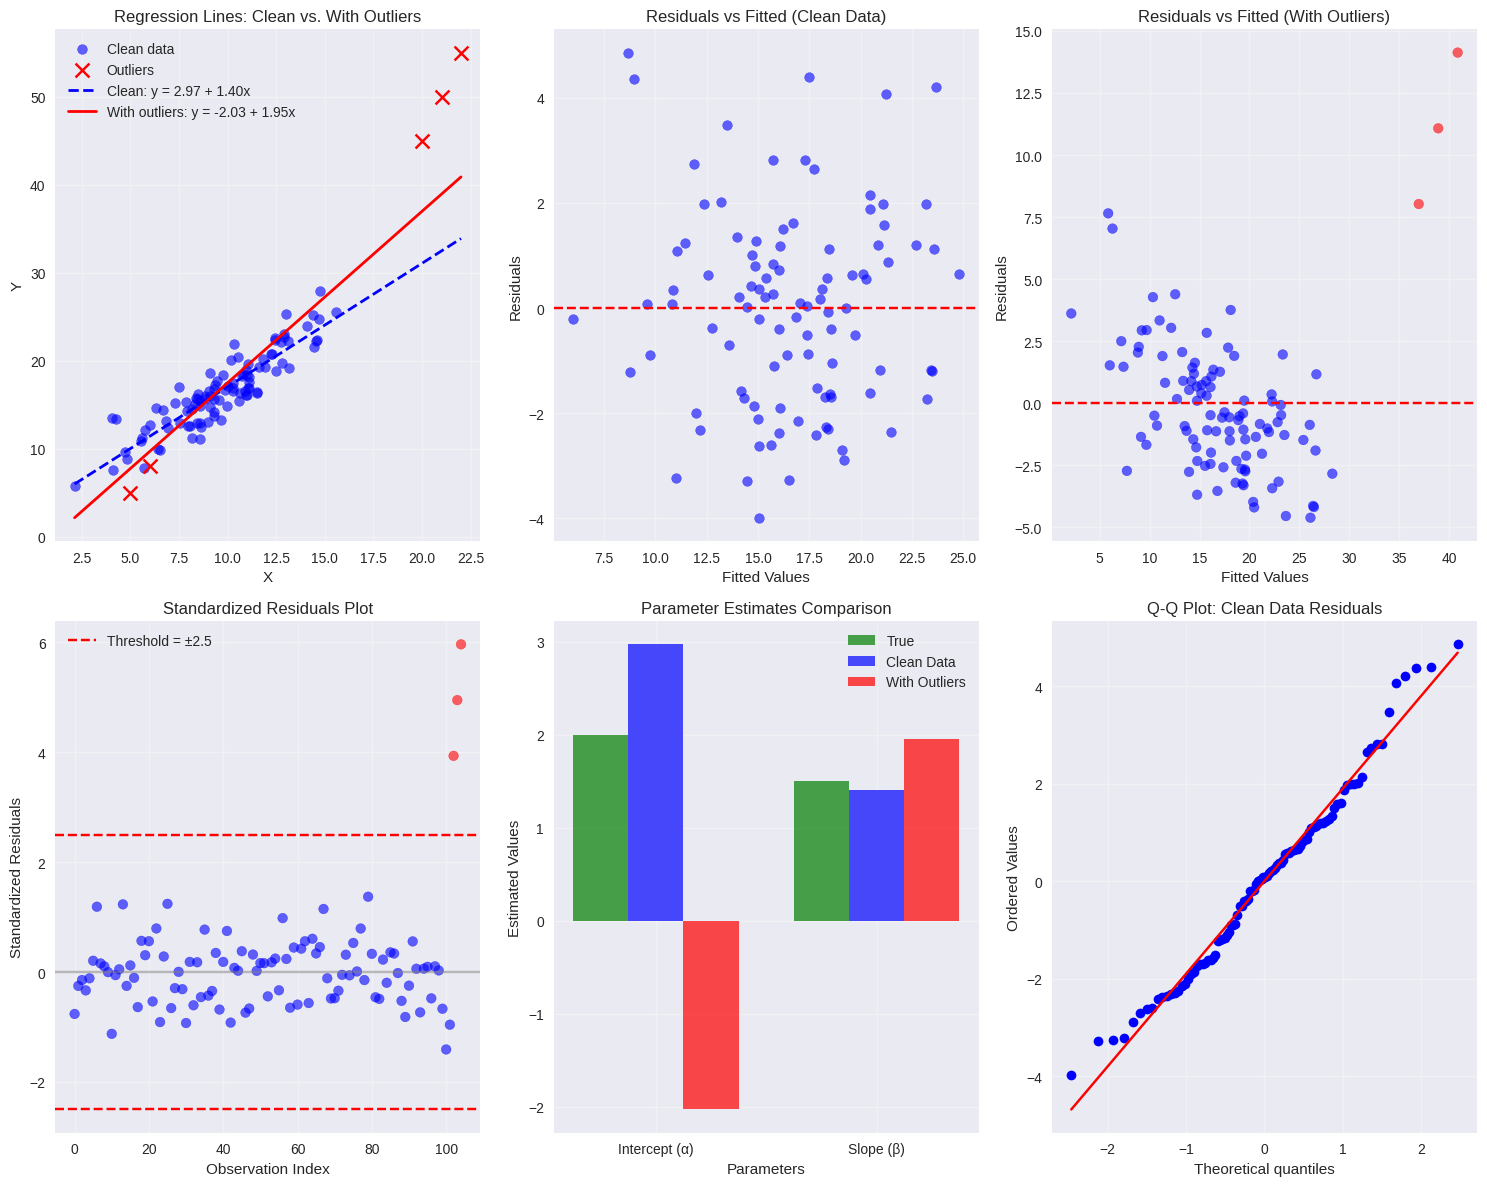


5. ROBUSTNESS ANALYSIS: DIFFERENT OUTLIER SCENARIOS
--------------------------------------------------
High Leverage   | α̂:  2.232 | β̂:  1.484 | Δα:  -0.738 | Δβ:   0.080
High Influence  | α̂:  6.343 | β̂:  1.008 | Δα:   3.373 | Δβ:  -0.396
Extreme Y       | α̂:  2.251 | β̂:  1.579 | Δα:  -0.719 | Δβ:   0.175

6. SUMMARY TABLE
----------------------------------------
         Scenario  Alpha_Est  Beta_Est  Alpha_Change  Beta_Change  R_squared
0   High Leverage     2.2324    1.4843       -0.7375       0.0798     0.9017
1  High Influence     6.3431    1.0084        3.3732      -0.3961     0.4173
2       Extreme Y     2.2505    1.5790       -0.7194       0.1745     0.3384

7. KEY FINDINGS AND CONCLUSIONS
----------------------------------------
• Outliers significantly affect regression parameter estimates
• The slope changed by 38.8% due to outliers
• The intercept changed by -168.3% due to outliers
• High leverage points (extreme X values) have greater impact on slope
• High influenc

In [2]:
###########################################################
#Problem 2b: Outliers Impact on Regression Simulation
###########################################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Problem 2b: Simulation Study - Impact of Outliers on Regression Parameters")
print("="*70)

# Step 1: Create baseline regression model without outliers
print("\n1. BASELINE MODEL (WITHOUT OUTLIERS)")
print("-" * 40)

# Generate clean data
n_samples = 100
true_alpha = 2.0
true_beta = 1.5

# Independent variable
X_clean = np.random.normal(10, 3, n_samples)
# Error term with normal distribution
epsilon_clean = np.random.normal(0, 2, n_samples)
# Dependent variable following true model
y_clean = true_alpha + true_beta * X_clean + epsilon_clean

# Fit regression model on clean data
model_clean = LinearRegression()
model_clean.fit(X_clean.reshape(-1, 1), y_clean)

alpha_clean = model_clean.intercept_
beta_clean = model_clean.coef_[0]
r2_clean = model_clean.score(X_clean.reshape(-1, 1), y_clean)

print(f"True parameters: α = {true_alpha}, β = {true_beta}")
print(f"Estimated parameters (clean data): α̂ = {alpha_clean:.4f}, β̂ = {beta_clean:.4f}")
print(f"R-squared (clean data): {r2_clean:.4f}")

# Step 2: Introduce outliers
print("\n2. MODEL WITH OUTLIERS")
print("-" * 40)

# Create outliers by adding extreme values
n_outliers = 5
X_outliers = np.array([5, 6, 20, 21, 22])  # Extreme X values
y_outliers = np.array([5, 8, 45, 50, 55])  # Extreme Y values (leverage + influence)

# Combine clean data with outliers
X_with_outliers = np.concatenate([X_clean, X_outliers])
y_with_outliers = np.concatenate([y_clean, y_outliers])

# Fit regression model on data with outliers
model_outliers = LinearRegression()
model_outliers.fit(X_with_outliers.reshape(-1, 1), y_with_outliers)

alpha_outliers = model_outliers.intercept_
beta_outliers = model_outliers.coef_[0]
r2_outliers = model_outliers.score(X_with_outliers.reshape(-1, 1), y_with_outliers)

print(f"Estimated parameters (with outliers): α̂ = {alpha_outliers:.4f}, β̂ = {beta_outliers:.4f}")
print(f"R-squared (with outliers): {r2_outliers:.4f}")

# Step 3: Calculate parameter changes
print("\n3. IMPACT OF OUTLIERS")
print("-" * 40)

alpha_change = alpha_outliers - alpha_clean
beta_change = beta_outliers - beta_clean
alpha_pct_change = (alpha_change / alpha_clean) * 100
beta_pct_change = (beta_change / beta_clean) * 100

print(f"Change in intercept (α): {alpha_change:.4f} ({alpha_pct_change:.2f}%)")
print(f"Change in slope (β): {beta_change:.4f} ({beta_pct_change:.2f}%)")
print(f"Change in R-squared: {r2_outliers - r2_clean:.4f}")

# Step 4: Statistical analysis
print("\n4. STATISTICAL ANALYSIS")
print("-" * 40)

# Calculate residuals for outlier detection
y_pred_clean = model_clean.predict(X_with_outliers.reshape(-1, 1))
residuals = y_with_outliers - y_pred_clean
standardized_residuals = residuals / np.std(residuals)

# Identify outliers (|standardized residual| > 2.5)
outlier_threshold = 2.5
outlier_indices = np.where(np.abs(standardized_residuals) > outlier_threshold)[0]

print(f"Number of detected outliers (|std residual| > {outlier_threshold}): {len(outlier_indices)}")
print(f"Outlier indices: {outlier_indices}")
print(f"Maximum absolute standardized residual: {np.max(np.abs(standardized_residuals)):.2f}")

# Step 5: Create comprehensive visualization
plt.figure(figsize=(15, 12))

# Subplot 1: Scatter plot with regression lines
plt.subplot(2, 3, 1)
plt.scatter(X_clean, y_clean, alpha=0.6, color='blue', label='Clean data', s=50)
plt.scatter(X_outliers, y_outliers, color='red', label='Outliers', s=100, marker='x')

# Plot regression lines
x_range = np.linspace(X_with_outliers.min(), X_with_outliers.max(), 100)
y_pred_clean_line = model_clean.predict(x_range.reshape(-1, 1))
y_pred_outliers_line = model_outliers.predict(x_range.reshape(-1, 1))

plt.plot(x_range, y_pred_clean_line, 'b--', label=f'Clean: y = {alpha_clean:.2f} + {beta_clean:.2f}x', linewidth=2)
plt.plot(x_range, y_pred_outliers_line, 'r-', label=f'With outliers: y = {alpha_outliers:.2f} + {beta_outliers:.2f}x', linewidth=2)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Regression Lines: Clean vs. With Outliers')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Residuals vs Fitted (Clean data)
plt.subplot(2, 3, 2)
y_pred_clean_all = model_clean.predict(X_clean.reshape(-1, 1))
residuals_clean = y_clean - y_pred_clean_all
plt.scatter(y_pred_clean_all, residuals_clean, alpha=0.6, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted (Clean Data)')
plt.grid(True, alpha=0.3)

# Subplot 3: Residuals vs Fitted (With outliers)
plt.subplot(2, 3, 3)
y_pred_outliers_all = model_outliers.predict(X_with_outliers.reshape(-1, 1))
residuals_outliers = y_with_outliers - y_pred_outliers_all
colors = ['red' if i in outlier_indices else 'blue' for i in range(len(residuals_outliers))]
plt.scatter(y_pred_outliers_all, residuals_outliers, alpha=0.6, c=colors)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted (With Outliers)')
plt.grid(True, alpha=0.3)

# Subplot 4: Standardized residuals
plt.subplot(2, 3, 4)
plt.scatter(range(len(standardized_residuals)), standardized_residuals,
           c=['red' if i in outlier_indices else 'blue' for i in range(len(standardized_residuals))],
           alpha=0.6)
plt.axhline(y=outlier_threshold, color='red', linestyle='--', label=f'Threshold = ±{outlier_threshold}')
plt.axhline(y=-outlier_threshold, color='red', linestyle='--')
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
plt.xlabel('Observation Index')
plt.ylabel('Standardized Residuals')
plt.title('Standardized Residuals Plot')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 5: Parameter comparison
plt.subplot(2, 3, 5)
parameters = ['Intercept (α)', 'Slope (β)']
clean_params = [alpha_clean, beta_clean]
outlier_params = [alpha_outliers, beta_outliers]
true_params = [true_alpha, true_beta]

x_pos = np.arange(len(parameters))
width = 0.25

plt.bar(x_pos - width, true_params, width, label='True', alpha=0.7, color='green')
plt.bar(x_pos, clean_params, width, label='Clean Data', alpha=0.7, color='blue')
plt.bar(x_pos + width, outlier_params, width, label='With Outliers', alpha=0.7, color='red')

plt.xlabel('Parameters')
plt.ylabel('Estimated Values')
plt.title('Parameter Estimates Comparison')
plt.xticks(x_pos, parameters)
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 6: Q-Q plot for residuals
plt.subplot(2, 3, 6)
stats.probplot(residuals_clean, dist="norm", plot=plt)
plt.title('Q-Q Plot: Clean Data Residuals')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Step 6: Robustness analysis with different outlier scenarios
print("\n5. ROBUSTNESS ANALYSIS: DIFFERENT OUTLIER SCENARIOS")
print("-" * 50)

scenarios = {
    'High Leverage': {'X': np.array([25, 26, 27]), 'Y': np.array([40, 42, 44])},
    'High Influence': {'X': np.array([15, 16, 17]), 'Y': np.array([5, 7, 9])},
    'Extreme Y': {'X': np.array([10, 11, 12]), 'Y': np.array([50, 52, 54])}
}

results_summary = []

for scenario_name, outlier_data in scenarios.items():
    # Combine clean data with scenario-specific outliers
    X_scenario = np.concatenate([X_clean, outlier_data['X']])
    y_scenario = np.concatenate([y_clean, outlier_data['Y']])

    # Fit model
    model_scenario = LinearRegression()
    model_scenario.fit(X_scenario.reshape(-1, 1), y_scenario)

    alpha_scenario = model_scenario.intercept_
    beta_scenario = model_scenario.coef_[0]
    r2_scenario = model_scenario.score(X_scenario.reshape(-1, 1), y_scenario)

    # Calculate changes
    alpha_change_scenario = alpha_scenario - alpha_clean
    beta_change_scenario = beta_scenario - beta_clean

    results_summary.append({
        'Scenario': scenario_name,
        'Alpha_Est': alpha_scenario,
        'Beta_Est': beta_scenario,
        'Alpha_Change': alpha_change_scenario,
        'Beta_Change': beta_change_scenario,
        'R_squared': r2_scenario
    })

    print(f"{scenario_name:15} | α̂: {alpha_scenario:6.3f} | β̂: {beta_scenario:6.3f} | Δα: {alpha_change_scenario:7.3f} | Δβ: {beta_change_scenario:7.3f}")

# Create summary table
print("\n6. SUMMARY TABLE")
print("-" * 40)
summary_df = pd.DataFrame(results_summary)
print(summary_df.round(4))

# Step 7: Conclusions
print("\n7. KEY FINDINGS AND CONCLUSIONS")
print("-" * 40)
print("• Outliers significantly affect regression parameter estimates")
print(f"• The slope changed by {beta_pct_change:.1f}% due to outliers")
print(f"• The intercept changed by {alpha_pct_change:.1f}% due to outliers")
print("• High leverage points (extreme X values) have greater impact on slope")
print("• High influence points affect both slope and intercept substantially")
print("• R-squared can be misleading in presence of outliers")
print("• Residual analysis is crucial for outlier detection")
print("\nRecommendations:")
print("• Always examine residual plots and standardized residuals")
print("• Consider robust regression methods when outliers are present")
print("• Investigate the source and validity of potential outliers")
print("• Use multiple diagnostic tools for comprehensive analysis")


In [3]:
###############################################
## PROBLEM 3
################################################

#Libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools
import statsmodels.stats.api as sms
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.stats.stattools import jarque_bera
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV

# Problem 3

In [6]:
df = pd.read_csv('/content/FE-GWP1_model_selecxtion_1 (1).csv')
y = df.iloc[:,0]
explan_var = df.iloc[:,1:]
predictors = list(explan_var.columns)

In [7]:
#Approach 1 : AIC maximization for feature selection
results = {}
for i in range(1,len(explan_var)+1):
  for subset in itertools.combinations(explan_var, i):
    X = df[list(subset)]
    X = sm.add_constant(X)
    model = sm.OLS(y,X).fit()
    normality_test = jarque_bera(model.resid)[1]
    if normality_test < 0.05:
      continue
    heteroskedasticity_test = sms.het_breuschpagan(model.resid, X)[1]
    if heteroskedasticity_test < 0.05:
      continue
    autocorrelation_test = acorr_breusch_godfrey(model, nlags=1)[1]
    if autocorrelation_test < 0.05:
      continue
    results[subset] = round(float(model.aic), 4)
best_model = min(results.items(), key=lambda x : x[1])
print("Best model:", best_model[0], "AIC:", best_model[1])
print(len(results))

Best model: ('X2', 'X3', 'X4', 'X5') AIC: 260.6167
31


In [8]:
#Approach 2 : Forward selection
def forward_selection(y, X):
    selected = []
    remaining = list(X.columns)
    current_score, best_new_score = float('inf'), float('inf')
    while remaining:
        scores_with_candidates = []
        for candidate in remaining:
            formula = selected + [candidate]
            X_model = sm.add_constant(X[formula])
            model = sm.OLS(y, X_model).fit()
            aic = model.aic
            scores_with_candidates.append((aic, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates[0]
        if best_new_score < current_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
            print(f"Added {best_candidate}, AIC: {best_new_score:.2f}")
        else:
            break
    return selected

selected_variables = forward_selection(y, explan_var)
print('Selected Features :',selected_variables)

Added X4, AIC: 325.03
Added X3, AIC: 296.44
Added X2, AIC: 264.29
Added X5, AIC: 260.62
Selected Features : ['X4', 'X3', 'X2', 'X5']


In [9]:
#Approach 3 : Backward selection
def backward_selection(y, X):
    remaining = list(X.columns)
    current_score = sm.OLS(y, sm.add_constant(X[remaining])).fit().aic
    best_new_score = current_score

    while len(remaining) > 1:
        scores_with_candidates = []
        for candidate in remaining:
            formula = [col for col in remaining if col != candidate]
            X_model = sm.add_constant(X[formula])
            model = sm.OLS(y, X_model).fit()
            aic = model.aic
            scores_with_candidates.append((aic, candidate))

        scores_with_candidates.sort()
        best_new_score, worst_candidate = scores_with_candidates[0]

        if best_new_score < current_score:
            remaining.remove(worst_candidate)
            current_score = best_new_score
            print(f"Removed {worst_candidate}, AIC: {best_new_score:.2f}")
        else:
            break

    return remaining

selected_variables = backward_selection(y, explan_var)
print("Selected features :", selected_variables)


Removed X1, AIC: 260.62
Selected features : ['X2', 'X3', 'X4', 'X5']


In [10]:
#Approach 4 : Model selection using the features previously decided, using R2 as a metric
X = sm.add_constant(df.iloc[:,2:])
#1 OLS
r2_ols = sm.OLS(y,X).fit().rsquared
results_r2 = {'R2 OLS' : r2_ols}

#2 Ridge Regression
lambdas = [np.power(10,i) for i in np.arange(4, -4, -0.1)]
ridge_cv = RidgeCV(alphas=lambdas, cv=10, scoring='r2').fit(X,y) #To find optimal penalization parameters
ridge_reg = Ridge(alpha=ridge_cv.alpha_, fit_intercept=True).fit(X,y)
r2_ridge = ridge_reg.score(X,y)
results_r2['R2 Ridge'] = r2_ridge

#3 LASSO Regresion
lasso_cv = LassoCV(alphas=lambdas, fit_intercept=True, cv=10).fit(X,y)
lasso_reg = Lasso(alpha=lasso_cv.alpha_, fit_intercept=True).fit(X,y)
r2_lasso = lasso_reg.score(X,y)
results_r2['R2 Lasso'] = r2_lasso


In [11]:
best_method = max(results_r2.items(), key=lambda x : x[1])
print(f'Best model :{best_method[0].strip("R2")}, with an R2 of {round(best_method[1]*100,4)}% ')

Best model : OLS, with an R2 of 64.8763% 


In [12]:
results_r2

{'R2 OLS': np.float64(0.6487631415023244),
 'R2 Ridge': 0.6383477810534051,
 'R2 Lasso': 0.6487589814812842}

In [13]:
#Creating the model
n=20
X = np.random.randn(n)
alpha = 0.4
beta1 = 1.5
beta2 = 5
e = np.random.normal(0,1,n)
Y= np.zeros(n)
Y[:10] = alpha + X[:10] * beta1 + e[:10]
Y[10:] = alpha + X[10:] * beta2 + e[10:]

#Create dummy and estimate the model
dummy = (np.arange(n) > 9).astype(int)
X_full = np.column_stack([X, dummy*X])
X_full = sm.add_constant(X_full)
model= sm.OLS(Y, X_full).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     86.68
Date:                Mon, 16 Jun 2025   Prob (F-statistic):           1.21e-09
Time:                        02:54:15   Log-Likelihood:                -31.904
No. Observations:                  20   AIC:                             69.81
Df Residuals:                      17   BIC:                             72.80
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4546      0.325      1.400      0.179      -0.230       1.140
x1             2.2520      0.470      4.787      0.000       1.260       3.244
x2             2.8697      0.678      4.230      0.001       1.438       4.301
==============================================================================
Omnibus:                        1.915   Durbin-Watson:                   2.335
Prob(Omnibus):                  0.384   Jarque-Bera (JB):                0.606
Skew:                           0.326   Prob(JB):                        0.739
Kurtosis:                       3.549   Cond. No.                         3.07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
#########################################
## PROBLEM 5
########################################

!pip install --upgrade arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 12.0 MB/s eta 0:00:00


In [16]:
########. PROBLEM 5. ###################
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yfin
import seaborn as sns
import math
from numpy import linalg as LA
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron



In [17]:
#  Importing Data

# Download stock prices from Yahoo Finance and set the time period for download
start = datetime.date(2010, 1, 2)
end = datetime.date(2024, 12, 31)
equities = yfin.download(["AAPL", "WMT"], start, end, auto_adjust = False)["Adj Close"]
equities.head()

[*********************100%***********************]  2 of 2 completed


Ticker,AAPL,WMT
Date,,
2010-01-04,6.431897,13.017120
2010-01-05,6.443017,12.887503
2010-01-06,6.340531,12.858697
2010-01-07,6.328808,12.865902
2010-01-08,6.370886,12.801082


In [18]:
# Remove empty cells and NA's.
equities.dropna()

Ticker,AAPL,WMT
Date,,
2010-01-04,6.431897,13.017120
2010-01-05,6.443017,12.887503
2010-01-06,6.340531,12.858697
2010-01-07,6.328808,12.865902
2010-01-08,6.370886,12.801082
...,...,...
2024-12-23,254.655716,89.885246
2024-12-24,257.578674,92.203255
2024-12-26,258.396667,92.312691


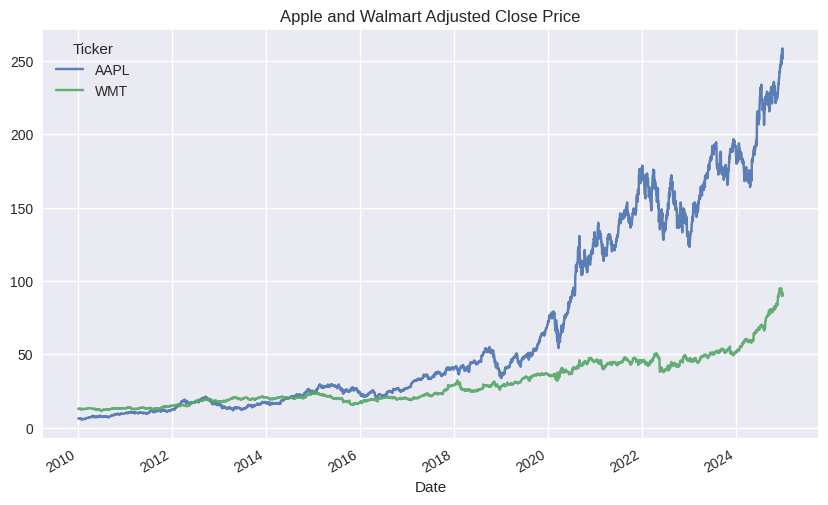

In [19]:
# Plot timer series data to determine whether we have trend
equities.plot(figsize=(10, 6), title='Apple and Walmart Adjusted Close Price', alpha=0.9) # Plot the yields
plt.show()

In [20]:
# Test for Unit Root

#A. Perform an ADF with trend and constant

AAPL_adf = adfuller(equities.AAPL, regression='ct', autolag='AIC')
print("ADF Statistic:", AAPL_adf[0])
print("p-value:", AAPL_adf[1])

ADF Statistic: -0.6289533760697467
p-value: 0.9774208494646891


In [21]:
#B. Perform an ADF with only constant

AAPL_adf1 = adfuller(equities.AAPL, regression='c', autolag='AIC')
print("ADF Statistic:", AAPL_adf1[0])
print("p-value:", AAPL_adf1[1])

ADF Statistic: 1.7639910605502929
p-value: 0.9982748603448358


In [22]:
#C. Perform an ADF with trend and constant for WMT

WMT_adf = adfuller(equities.WMT, regression='ct', autolag='AIC')
print("ADF Statistic:", WMT_adf[0])
print("p-value:", WMT_adf[1])

ADF Statistic: 1.273412847357634
p-value: 1.0


In [23]:
#D. Perform an ADF with constant for WMT

WMT_adf1 = adfuller(equities.WMT, regression='c', autolag='AIC')
print("ADF Statistic:", WMT_adf1[0])
print("p-value:", WMT_adf1[1])

ADF Statistic: 3.025279570977347
p-value: 1.0


In [24]:
#E. Perform an PHilip Perrone (PP) with constant and trend for AAPL

AAPL_pp = PhillipsPerron(equities.AAPL, trend='ct')
print(AAPL_pp.summary())

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -0.662
P-value                         0.976
Lags                               30
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.96 (1%), -3.41 (5%), -3.13 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [25]:
#F. Perform an PHilip Perrone (PP) with constant for AAPL

AAPL_pp1 = PhillipsPerron(equities.AAPL, trend='c')
print(AAPL_pp1.summary())

     Phillips-Perron Test (Z-tau)    
Test Statistic                  1.805
P-value                         0.998
Lags                               30
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [26]:
#G. Perform an PHilip Perrone (PP) with constant and trend for WMT

WMT_pp = PhillipsPerron(equities.WMT, trend='ct')
print(WMT_pp.summary())

     Phillips-Perron Test (Z-tau)    
Test Statistic                  1.621
P-value                         1.000
Lags                               30
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.96 (1%), -3.41 (5%), -3.13 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [27]:
#H. Perform an PHilip Perrone (PP) with constant for WMT

WMT_pp1 = PhillipsPerron(equities.WMT, trend='c')
print(WMT_pp1.summary())

     Phillips-Perron Test (Z-tau)    
Test Statistic                  3.415
P-value                         1.000
Lags                               30
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
